# Описание модели
В модели есть 3 вида агентов: `спонсоры`, `НКО` и `пациенты`. На каждом раунде спонсоры дают деньги одной НКО, НКО распределяет все деньги между лечением пациентов и рекламой, а пациенты выбирают организацию. Пациенты могут полностью излечиться в раунде, либо перейти в следующий раунд, если им не помогли.

Если организация получает в каком-либо раунде нулевой бюджет, то она выбывает из игры. Симуляция длится, пока не останется единственная организация с ненулевым бюджетом.

### Раунд симуляции
1. Спонсоры дают монетки НКО, основываясь на том, сколько потратили НКО на рекламу
2. НКО распределяют бюджет между лечением и рекламой
3. Пациенты обращаются в НКО, основываясь на том, сколько потратили НКО на медицину
4. НКО принимают всех пациентов и распределяют между ними бюджет
5. Часть пациентов вылечивается, вместо них приходят другие пациенты. Пациенты, которые не вылечились переходят в следующий раунд.


In [1]:
import numpy as np
import math

class SimpleAgentModel:
    
    class Donators:                        #  В модели 100 спонсоров.
        '''
         В каждом раунде спонсор отдаёт целиком 1 монетку j-той НКО, от которой он получил 
         самый сильный сигнал self.signal[i][j]. Значение сигнала  self.signal[i][j] - это значение, 
         сгенерированное из нормального распределения, дисперсия которого равна 9, а матожидание
         складывается из бюджета j-той организации на медицину и рекламу и коэффициентов 
         предпочтения i-того спонсора.
         
         self.signal[i][j] ∼ N(a, 9)
         a = self.med_coef[i] * medbudjet[j] + self.adv_coef[i] * advbudjet[j]
        '''
        
        def __init__(self):
            self.med_coef = 0              #  Коэффициент предпочтения медицины 
            self.adv_coef = 0              #  Коэффициент предпочтения рекламы
            self.signal = 0                #  Массив из сигналов. У каждого из 100 пациентов
                                           #  есть 10 сигналов от организаций.
            self.prev_donations = 0        #  Сколько раз спонсор жертвовал организациям
                                           #  в предыдущих ранудахю
            self.reset()
            
        def reset(self):
            self.med_coef = np.random.beta(2, 2, 100)
            self.adv_coef = np.zeros(100, np.float64)
            self.signal = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            self.prev_donations = np.zeros((100, 10), np.uint8)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] > half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i] 
            
    class Patients:                        #  В модели 100 пациентов.

        '''
         i-тый пациент в каждом раунде обращается за помощью в j-тую НКО, от которой он получил 
         самый сильный сигнал self.signal[i][j]. При этом, если пациент уже обращался в 
         j-тую организацию на прошлых раундах, то в этом раунде он туда не пойдёт.
        '''
        
        def __init__(self, graph_status = False, diag_count = 1):
            self.med_coef = 0              #  Коэффициент предпочтения медицины  
            self.adv_coef = 0              #  Коэффициент предпочтения рекламы                
            self.signal = 0                  
            self.choice = 0                #  Какую организацию выбирают пациенты в 
                                           #  текущем раунде?
            self.p_survival = 0            #  Вероятность излечения без помощи организации.
            self.visited = 0               #  Какие организации уже посетили пациенты?
            #self.prev_visited = 0
            self.budget = 0                #  Деньги, выделенные на конкретного 
                                           #  пациента в текущем раунде.
            self.count_cured = 0           #  Сколько всего вылечено пациентов?
            self.graph_status = graph_status
            self.prev_graph = 0
            self.graph = 0
            self.who_save = 0              #  Какая организация помогла в предыдущем раунде?
            self.not_new_patients = 0
            self.diag_count = diag_count
            self.diagnosis = 0             #  Номер диагноза у пациента, 
                                           #  если диагнозов > 1 в модели.
            self.reset()
            
        def reset(self):
            if self.graph_status:
                self.prev_graph = np.zeros((100, 100), bool)
                self.graph = np.zeros((100, 100), bool)
                for i in range(100):
                    for j in range(i + 1, 100):
                        self.graph[i][j] = np.random.binomial(n = 1, p = 0.5)
                        self.graph[j][i] = self.graph[i][j]
                        # NetworkX - посмотреть 
                #self.graph = np.random.binomial(n = 1, p = 0.25, size = (100, 100))
            
            self.med_coef = np.random.beta(2, 2, 100)  #  Какие параметры бета-распредления выставить?
            self.adv_coef = np.zeros(100, np.float64)
            
            half = np.float64(0.5)
            for i in range(100):
                if self.med_coef[i] < half:
                    self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
                else:
                    self.adv_coef[i] = 1 - self.med_coef[i]
                    
            self.diagnosis = np.random.randint(0, self.diag_count, 100)
            self.signal = np.array([np.random.normal(0, 9, 10) for i in range(100)], np.float64)
            self.choice = np.zeros(100, np.int8)
            self.p_survival = np.random.beta(2, 5, 100)   #  возможно, надо взять разные распределения
            if self.diag_count > 1:
                for i in range(100):
                    if self.diagnosis[i] == 1:
                        self.p_survival[i] = self.p_survival[i] / 2
            self.visited = np.zeros((100, 10), bool)
            self.prev_visited = np.zeros((100, 10), bool)
            self.who_save = np.full(100, -1)           
            self.not_new_patients = np.full(100, -1)           
            self.budget = np.zeros(100, np.int8)
            self.count_cured = np.int8(0)
            
        def new_patient(self, i):
            if self.graph_status:
                self.graph[i] = np.random.binomial(n = 1, p = 0.5, size = 100)
                self.graph[i][i] = 0
                for j in range(100):
                    self.graph[j][i] = self.graph[i][j]

            if self.diag_count > 1:
                self.diagnosis[i] = np.random.randint(0, self.diag_count)
            for j in range(10):
                self.visited[i][j] = False
            self.p_survival[i] = np.random.beta(2, 2)
            if  self.diag_count > 1:
                self.p_survival[i] = self.p_survival[i] / 2
            self.med_coef[i] = np.random.beta(2, 2)
            if self.med_coef[i] < np.float64(0.5):
                self.adv_coef[i], self.med_coef[i] = self.med_coef[i], 1 - self.med_coef[i]
            else:
                self.adv_coef[i] = 1 - self.med_coef[i]
            
    class Organizations:

        '''
        Организация получает бюджет от спонсоров. Если бюджет нулевой, то НКО выбывает из игры. 
        Если она получает ненулевой бюджет, то часть денег она тратит на медицину 
        self.med_coef[j] * self.budget[j], а часть на рекламу self.adv_coef[j] * self.budget[j]
        '''
        
        def __init__(self, diag_count = 1):
            self.budget = 0              #  Общий бюджет каждой организации в текущем раунде
            self.med_budget = 0
            self.adv_budget = 0
            self.med_coef = 0            #  Коэффициент трат на медицину.
            self.is_lose = 0             #  Выбыла ли организация?
            self.prev_patients = 0
            self.patients = 0            #  Индексы пациентов, которые поступили в 
                                         #  организацию в текущем раунде.
            self.laps = 0                #  Сколько кругов продержалась организация?
            self.saved_lives = 0         #  Сколько жизней спасла организация?
            self.all_patients = 0        #  Сколько пациентов поступило в организацию
                                         #  на протяжении всей симцляции?
            self.tax = 0                 #  Процент налога на рекламу.
            self.diag_count = diag_count
            self.reset(tax)
            
        def reset(self, new_tax = 0):
            self.budget = np.zeros(10, np.uint8)
            self.med_budget = np.zeros(10)
            self.adv_budget = np.zeros(10)
            self.med_coef = np.random.beta(2, 2, 10)  #   Какие параметры бета-распредления выставить?
            self.is_lose = np.zeros(10, bool)
            self.patients = [[] for i in range(10)]
            self.prev_patients = [[] for i in range(10)]
            self.laps = np.zeros(10, np.uint32)
            self.saved_lifes = np.zeros((self.diag_count, 10), np.uint16)
            self.all_patients = np.zeros(10, np.uint16)
            self.tax = new_tax

    '''
    Конец описания подклассов.
    '''
    
    def __init__(self, graph_status = False, diag_count = 1):
        self.donators = SimpleAgentModel.Donators()
        self.patients = SimpleAgentModel.Patients(graph_status, diag_count)
        self.organizations = SimpleAgentModel.Organizations(diag_count)
        
    def donation(self):
        for i in range(100): 
            ind = np.argmax(self.donators.signal[i]) 
            self.donators.prev_donations[i][ind] += 1
            self.organizations.budget[ind] += 1        
            
    def budget_med_or_adv(self):
        for i in range(10):
            if self.organizations.budget[i] == 0:
                self.organizations.is_lose[i] = True
            else:
                self.organizations.laps[i] += 1
                self.organizations.med_budget[i] = self.organizations.budget[i] * self.organizations.med_coef[i]
                self.organizations.adv_budget[i] = (self.organizations.budget[i] - self.organizations.med_budget[i]) * (1 - self.organizations.tax)
                self.organizations.budget[i] = 0

    def check_friends(self, patient, org):
        friends_count = 0
        surv = 0
        #  если у нас новый пациент, то непонятно, как смотреть, вылечились ли его друзбя где-то
        #  надо смотреть, что они были в предыдущем круге
        #  он дружит с человеком, который раньше был на этом месте? или с новым пациентом?
        
        #if self.patients.who_save[patient] != -1:
        #    friends = np.array([friend for friend in range(100) if (patients.graph[patient][friend] and patients.who_save[friend] == -1)])
        #else:
        friends = np.nonzero(self.patients.prev_graph[patient])[0]
        for friend in friends:
            if self.patients.prev_visited[patient][org]:
                friends_count += 1
                if self.patients.who_save[friend] == org:
                    surv += 1    
        return (friends_count > 2 and (surv / friends_count) < 0.5) #  возможно, взять коэффицент не 0.5
        #  А если кто-то умер в организации? Достаточно и одного человека мб. 
    
        #for patient in self.organizations.prev_patients[j]:  # Учитываю только пациентов, бывших на последнем раунде в этой органмзации
        #    if self.patients.prev_graph[i][patient]:
        #        friends += 1
        #        if self.patients.not_new_patients[patient]:
                        #
                    #if self.patients.prev_visited[patient][j]:  #  Как понять, что пациент выжил?
                    #    surv += 1
        #if friends > 3 and surv / friends < 0.5:
        #    self.patients.signal[i][j] = -100
        #    continue
                

    def choose_organization(self):  
        #  Что делать, если у нас сейчас новый пациент? Смотрим
        #  Как вообще смотреть на граф? На этом круге или на предыдущем?
        
        for i in range(100):
            for j in range(10):
                if self.patients.visited[i][j] or self.organizations.is_lose[j]:
                    self.patients.signal[i][j] = -100
                    continue
                a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                #  Если есть граф
                if self.patients.graph_status and self.patients.who_save[i] == -1 and self.check_friends(i, j): 
                    self.patients.signal[i][j] = -100
                    continue
                self.patients.signal[i][j] = np.random.normal(a, 9)
                
            ind = np.argmax(self.patients.signal[i])
            if self.patients.signal[i][ind] == -100:
                for j in range(10):
                    self.patients.visited[i][j] = False
                    if not self.organizations.is_lose[j]:
                        a =  self.organizations.med_budget[j] * self.patients.med_coef[i] + self.organizations.adv_budget[j] * self.patients.adv_coef[i]
                        self.patients.signal[i][j] = np.random.normal(a, 9, 1)[0]
                ind = np.argmax(self.patients.signal[i])
                   
            self.patients.visited[i][ind] = True
            self.patients.choice[i] = ind
            self.organizations.all_patients[ind] += 1
            self.organizations.patients[ind].append(i)
                                                                                                                                                
    def budget_between_patient(self): #  Может ли организация не принять?
        for i in range(10):
            self.organizations.prev_patients[i] = self.organizations.patients[i]  #  Сохраняем
            
            if (self.organizations.is_lose[i]):
                continue
            #survive = [self.patients.p_survival[self.organizations.patients[i][j]] for j in range(len(self.organizations.patients[i]))]
            #surv_sum = sum(survive)
            #proportion = [prob / surv_sum for prob in survive]
            if len(self.organizations.patients[i]) > 0:
                patient_budget = self.organizations.med_budget[i] / len(self.organizations.patients[i])
            else:
                patient_budget = 0
                                                                    
            for patient in (self.organizations.patients[i]):
                #ind = self.organizations.patients[i][j]
                self.patients.budget[patient] = patient_budget          
            self.organizations.patients[i] = []
        
    def survival(self):                 #  поменять коэффициенты в ???
        if  self.patients.graph_status:
            self.patients.prev_graph = self.patients.graph   #  старые связи с пациентами (часть пациентов в новом кругу может быть заменена новыми)
            self.patients.prev_visited = self.patients.visited
        for i in range(100):            #  logit ~ (0.5, 1) - p выживаемости. 
                                        #  У нас в любом случае высокая вероятность выжить!!

            s_i = (1 / (1 + math.pow(math.e, -(-0.5 + self.patients.p_survival[i] + self.patients.budget[i]) ))) - 0.2  #  коэффициент эффективности трат
            if np.random.binomial(1, s_i): #  Пациент вылечился (Биномиальное распределение)
                self.patients.count_cured += 1
                self.patients.new_patient(i)
                self.organizations.saved_lifes[self.patients.diagnosis[i]][self.patients.choice[i]] += 1
                self.patients.who_save[i] == self.patients.choice[i]
            else:
                self.patients.who_save[i] == -1
        
    def set_new_preferences(self):
        for i in range(100):
            for j in range(10):
                if self.organizations.is_lose[j]:
                    self.donators.signal[i][j] = -100
                    continue
                a = self.donators.med_coef[i] * self.organizations.med_budget[j] + self.donators.adv_coef[i] * self.organizations.adv_budget[j]
                if self.patients.diag_count > 1:
                    a += (2 / (0.5 + (1.5 /(math.log(math.exp(1), math.exp(1) + self.organizations.saved_lifes[1][j])))))
                #self.donators.signal[i][j] = np.random.normal(a, 9)
                self.donators.signal[i][j] = np.random.normal(a, 9 / (1 + self.donators.prev_donations[i][j]))
        self.organizations.budget = np.zeros(10, np.int8)
        self.organizations.med_budget = np.zeros(10, np.int8)
        self.organizations.adv_budget = np.zeros(10, np.int8)
        
    
    def lap(self):
        self.donation()        
        self.budget_med_or_adv()
        self.choose_organization()
        self.budget_between_patient()
        self.survival()
        self.set_new_preferences()
        
    def simulation(self):
        self.donators.reset()
        self.patients.reset()
        self.organizations.reset(self.organizations.tax)
        i = 0
        while True:
            i += 1
            self.lap()
            if sum(self.organizations.is_lose == True) == 9:
                winner_ind = 0
                for j in range(10):
                    if not self.organizations.is_lose[j]:
                        winner_ind = j
                        break
                #print(f'laps: {i}, saved: {self.patients.count_cured}, per_lap: {self.patients.count_cured / i}')
                return i, self.organizations.laps, self.organizations.med_coef, self.organizations.saved_lifes, self.organizations.all_patients, winner_ind
            
   

In [9]:
from matplotlib import pyplot as plt
from statistics import mean
import pandas as pd
import scipy.stats as st

tax_results = pd.DataFrame(columns = ['Tax, %', 'Average med_coef', 'Average win_med_coef', 'confidence interval (win med)', 'Av saved fraction', 'Av win saved fraction', 'confidence interval (win saved)', 'Av end lap', 'Corr(laps, medcoef)', 'Corr(Saved frac, medcoef)'])


def tax_sim(df, tax = 0., print_status = False, gr_status = False, diagnosis_count = 1):
    total_laps = np.zeros(1000, np.uint16)
    total_med_coef = np.zeros(1000)
    total_saved_lifes = np.zeros(1000)
    total_patients = np.zeros(1000, np.uint16)
    saved_fraction = np.zeros(1000)
    
    game_end = np.zeros(100, np.uint16)
    winner_med = np.zeros(100)
    winner_saved_fraction = np.zeros(100)
    
    Model = SimpleAgentModel(graph_status = gr_status, diag_count = diagnosis_count)
    Model.organizations.tax = tax
    
    for i in range(100):
        end, laps, med_coef, saved_lifes, total_pat, win_ind = Model.simulation()
        for j in range(i * 10, i * 10 + 10):
            total_laps[j] = laps[j % 10]
            total_med_coef[j] = round(med_coef[j % 10], 3)
            #print(saved_lifes)
            total_saved_lifes[j] = saved_lifes[0][j % 10]
            total_patients[j] = total_pat[j % 10]
        game_end[i] = end
        winner_med[i] = med_coef[win_ind]
        winner_saved_fraction[i] = saved_lifes[0][win_ind] / total_pat[win_ind]
    for i in range(1000):
        saved_fraction[i] = total_saved_lifes[i] / total_patients[i]

    winner_med_inter = st.t.interval(alpha = 0.99, df = len(winner_med)-1, loc = np.mean(winner_med), scale = st.sem(winner_med))
    winner_savedfrac_inter = st.t.interval(alpha = 0.99, df = len(winner_saved_fraction)-1, loc = np.mean(winner_saved_fraction), scale = st.sem(winner_saved_fraction))
    
    corr_lap_medcoef = np.corrcoef(total_laps, total_med_coef)
    corr_savedfrac_med_coef =  np.corrcoef(total_saved_lifes, total_med_coef)
    #df.loc[len(df.index)] = [tax, round(np.mean(total_med_coef), 4), round(np.mean(winner_med), 4), 
    #                         round(np.mean(saved_fraction), 4), round(np.mean(winner_saved_fraction), 4), 
    #                         round(np.mean(game_end), 4), corr_lap_medcoef[0, 1], corr_savedfrac_med_coef[0, 1]]
    print(winner_med_inter[0])
    
    df.loc[len(df.index)] = [tax, round(np.mean(total_med_coef), 4), 
                             winner_med_inter[0],  winner_med_inter[1],
                             round(np.mean(saved_fraction), 4),
                             winner_savedfrac_inter[0],  winner_savedfrac_inter[1],                              
                             round(np.mean(game_end), 4), corr_lap_medcoef[0, 1], corr_savedfrac_med_coef[0, 1]]

    
    #saved_fraction =[total_saved_lifes[i] / total_patients[i] for i in range(len(total_patients))] 
    #total_med_inter = st.t.interval(alpha = 0.99, df = len(total_med_coef)-1, loc = np.mean(total_med_coef), scale = st.sem(total_med_coef))
    #winner_med_inter = st.t.interval(alpha = 0.99, df = len(winner_med)-1, loc = np.mean(winner_med), scale = st.sem(winner_med))

                             
                     
    if print_status:
        print(f'Average med_coef: {round(mean(total_med_coef), 4)}')     #  0.4981   0.4997
        print(f'Average winner med_coef: {round(mean(winner_med), 4)}')  #  0.5219   0.5385
        print(f'Average saved fraction: {round(mean(saved_fraction), 4)}')         
        print(f'Average winner saved fraction: {round(mean(winner_saved_fraction), 4)}')
        print(f'\nAverage end_lap: {round(mean(game_end), 4)}')
        
        print(f'\nStandart deviation med_coef: {round(np.std(total_med_coef), 4)}')     #  0.2249 
        print(f'Standart deviation winner med_coef: {round(np.std(winner_med), 4)}')  #   0.2126  
        print(f'Standart deviation saved fraction: {round(np.std(saved_fraction), 4)}')     #  0.2249 
        print(f'Standart deviation winner saved fraction: {round(np.std(winner_saved_fraction), 4)}')  #   0.2126  
        
        #plt.scatter(total_med_coef, total_laps, s = 1)
        #plt.show()
        
        plt.hist(game_end)
        plt.show()
        
        plt.hist(total_med_coef)
        plt.show()
        
        plt.hist(winner_med)  #   
        plt.show()
        
for k in range(0, 75, 5):
    tax_sim(tax_results, tax = k / 100, print_status = False, gr_status = False, diagnosis_count = 1)
    
tax_results

#  Гипотеза: на начальном этапе медицинский коэффициент не особо на что-то влияет, 
#  потому что на первых этапах (без репутации) бюджет формируется по большей части за счет рекламы.
#  Если нет денег, то никто и не спасается.
#  Можно посмотреть на количество денег, которые получают пациенты и фракцию выживших.

#  А что если будем давать деньги наоборот тем, кто с наименьшей вероятностью выживет.

#  Вероятно, на начальном этапе выгоднее вкладываться в рекламу, а потом уже при неком уровне 
#  известности вкладываться в медицину

#  А как часто доноры меняют организацию? А повлияет ли на эффективность и медицинские коэффициенты, 
#  если доноры будут чаще менять организацию? (наверное, да, потому что реклама будет больше влиять)

0.22031385959977506
0.20874378160124107
0.18896794558332447
0.1962689438152076
0.18627292538167178
0.22382757561318628
0.22465320847066433
0.20224189926983527
0.26364702251859956
0.31663485752119913
0.39324004515876015
0.43990313790092145
0.5600013765185219
0.6350269853053939
0.6710699266891453


,"Tax, %",Average med_coef,Average win_med_coef,confidence interval (win med),Av saved fraction,Av win saved fraction,confidence interval (win saved),Av end lap,"Corr(laps, medcoef)","Corr(Saved frac, medcoef)"
0,0.00,0.5037,0.220314,0.284825,0.2708,0.273553,0.288798,6.82,-0.130841,-0.340375
1,0.05,0.5033,0.208744,0.276450,0.2685,0.267953,0.285595,6.69,-0.162489,-0.351440
2,0.10,0.4906,0.188968,0.254386,0.2711,0.273566,0.288851,7.57,-0.127041,-0.337055
3,0.15,0.5040,0.196269,0.259919,0.2727,0.275637,0.291321,7.93,-0.112286,-0.321776
4,0.20,0.5095,0.186273,0.256650,0.2741,0.273706,0.290758,8.57,-0.054232,-0.302479
5,0.25,0.5021,0.223828,0.290048,0.2756,0.275775,0.290524,9.19,-0.108703,-0.256973
6,0.30,0.5026,0.224653,0.311641,0.2787,0.280597,0.297698,10.39,-0.016514,-0.164681
7,0.35,0.5019,0.202242,0.275350,0.2793,0.277204,0.293982,10.69,-0.060681,-0.213922
8,0.40,0.4927,0.263647,0.362502,0.2814,0.284674,0.300606,12.68,-0.114582,-0.071916
9,0.45,0.5030,0.316635,0.431916,0.2822,0.292417,0.310507,14.01,0.027939,0.080429


In [10]:
tax_results.to_excel(r'C:\Users\HOME\Documents\scripts\projects\AgentModel\model_results_2.xlsx', sheet_name = 'tax_donatmemorize_graph')

#"C:\Users\HOME\Documents\scripts\projects\AgentModel\Agent_model_NPO.ipynb"

В самом просто варианте я бы правило большинства использовал: если 2 из 3 знакомых обратилось, и им не помогли, то и этот человек в данную организацию не обратится. Более сложный сюжет - добавить репутационный параметр (процент знакомых, кому не помогли) в функцию выбора организации человеком.

### Количество доноров
- Что если повышение количества спонсоров повысит коэффициенты на медицину в долгосроке? Не надо будет биться за каждый рубль и можно будет сосредоточиться на лечении
- Посмотреть статистику количества спонсоров на количество организации. 

### Накопление опыта и специализация

### Излечение, смерть и демография
- сложновато

### Какие механизмы лучше работают?
- репутационные или фискально-налоговые?
- Какой канал сильнее: рекламный или сетевой? 

### Распределение денег между пациентами
- Поровну
- Почитать, как вообще НКО распределеют деньги между пациентами
- Максимизация выживания пациентов. Как распределить бюджет? Оптимизационная задача
- Вероятность излечения: бюджет на пациента + изначальная вероятность выжить 

## Итоги
- Записать модель в формулах с комментариями
- Упростить, а не усложнить
- Ещё погуглить похожие модели: JASSS. Социология НКО. Как принимают решения НКО?
- К следующей неделе сделать текстовое описание модели.
- Поменяет ли динамику модели, если НКО будет более объективно распределять бюджет
- Спросить когда-нибудь контакты для глубинного интервью? Есть ли отказы? Как распределяют бюджет?

### 29.05
- Можно посмотреть на 2 диагноза. Диагноз 1 требует более сложного лечения, изначальная выживаемость ниже в 2 раза, но если пациента вылечивают, то это значительный информационный повод. Диагноз 2 вероятность выживания апрорная выше, но никакого информационного бонуса.
- Можно как-то прописать бонус в сигнале для доноров. Как это будет влиять на параметры модели?
- Добавить к сигналу ss сколько на прошлом раунде вылечилось сложных пациентов.
- Параметр эффективности как-то должен быть связан с количеством вылеченных пациентов.
- Можно завести коэффициент exp

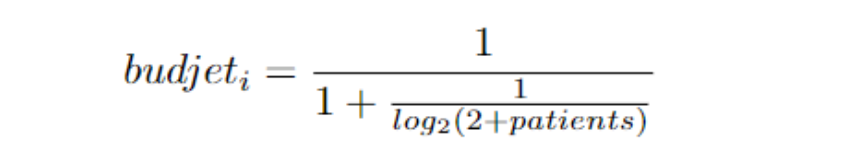

- А может НКО берет не всех пациентов?? На будущее
- Суббота 3 часа

- Коэффициент эффективности затрат в вероятности выживания. Не должно напрямую влиять на сигнал донорам.
- Перевзвесить medbudj. Умножить medbudj на Процент успешно вылеченных пациентов в прошлом раунде в сигнале к донору.
- Сохранить, какая часть трат пошла на диагноз 1 и на дигноз 2. medbudj(процент выживших  * диагноз1 + процент выживших * диагноз 2 * 4) В 4 раза больше внимания к успеху. Это в сигнале донора.
- Сигнал пациентов. Учесть динамику диагнозов. Насколько много medpi * medbudj(diag k) * пропорция вылеченных. Смотрят на эффективность работы именно по его диагнозу.
- Можно смотреть и сравнивать вложенные средства и выживаемость разных пациентов.
- Коэффициенты от равномерного распределения.



# Что описать в работе
## 
1) Как выживаемость зависит от трат на медицину и на рекламу
2) Сколько тратят в среднем на медицину и на рекламу при разных условиях. Доверительные интервалы средних
3) Налоги. Есть ли зависимость средних затрат на медицину от ставку налога на рекламу? Можно ли заставить больше тратить на медицину
4) Модель слухов. Но ничего не меняется. А сложность вычислительной модели увеличивается.
5) Разные диагнозы. Специализируются ли разные организации? Накапливает ли опыт? Влияет ли это на выживаемость? По логике должны привлекать организации, которые бустят тяжело больных.
6) Доноры запоминают, кому донатили раньше

## будущие исследования
1) Улучшение коэффициента эффективности рекламы. Может, если реклама в целом будет эффективнее, то не будут люди настолько сильно вкладываться
2) Увеличение количества доноров. Может, коэффициент на медицину увеличи 
3) Неоднородность доноров. Доноры могут быть частными лицами, государством, корпорациями.
4) Включить оптимизационный механизм 

## Введение
1) **Актуальность**. Важный рынок. Академическая значимость. Были исследованы рынки донорских органов, были очень интересные результаты. Нет исследований. В России рынок НКО немаленький, большие благотворительные организации. Можно написать, актуальна проблема помощи . Уровень доступности к медицнсклй помощи плох к ряду заболеваний, поэтому требуются НКО, которые могли бы помочь. Описать нишу. Как должна быть организована система для максимальной эффективности. Наша узкая задача: Что влияет на успех НКО. Указываем на траты на медицину и на рекламу. Исследовательский вопрос: какие характеристики у наиболее эффективныъ НКО. 
2) **Введение**. Методологические ссылки. В каких контекстах возникает потребность в этих моделях: сложные процессы, когда сложно аналитически описать модель, много акторов. Можно сослаться на Андрея Сергеевича, на биологов. Для самых разных контекстов применяются эти модели
3) Цели, 
4) Актуальность. 
5) Глава 1. Обзор литераторы. Рассказать про нестандартные и нетипичные рынки. Где
6) Глава 2. Как устроена Бета-распределение даёт от 0 до 1, поэтому и взяли. Вообще можно попробовать и равномерное.

7) **Заключение** Результаты, ограничения 

In [124]:
for k in range(45, 60, 5):
    tax_sim(tax_results, tax = k / 100, print_status = False, graph_status = True)
    
tax_results

,"Tax, %",Average med_coef,Average win_med_coef,Av saved fraction,Av win saved fraction,Av end lap,"Corr(laps, medcoef)","Corr(Saved frac, medcoef)"
0,0.45,0.5018,0.3484,0.2911,0.3037,13.79,-0.003889,0.189014
1,0.50,0.5005,0.4373,0.2902,0.3137,14.99,-0.037132,0.284497
2,0.45,0.4959,0.4006,0.2895,0.3061,13.94,-0.030187,0.231009
3,0.50,0.5117,0.4427,0.2937,0.3173,15.14,-0.036171,0.286032
4,0.55,0.4987,0.5067,0.2928,0.3194,16.25,0.025750,0.374139


(0.4846466738214184, 0.5207868442148053)
(0.19641811158325614, 0.2692038293810151)


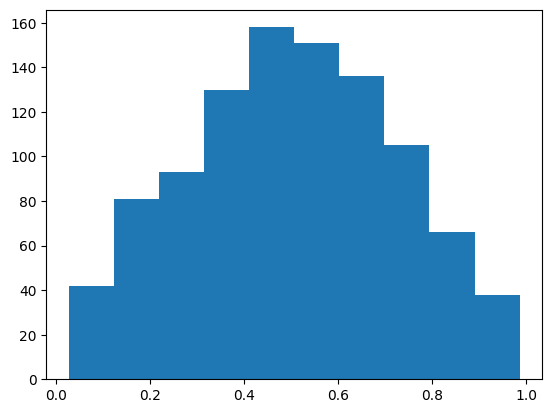

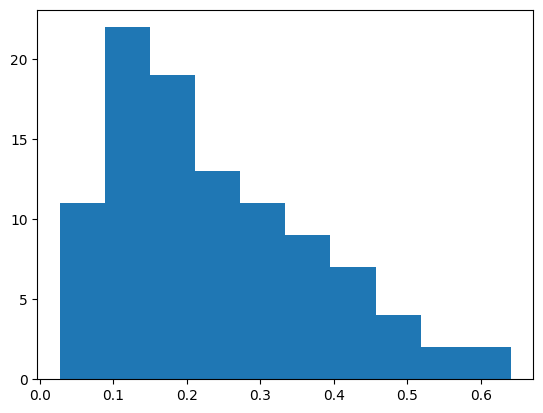

In [7]:
import scipy.stats as st

#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
#from plotnine.data import mtcars

print(st.t.interval(alpha = 0.99, df = len(total_med_coef)-1, loc = np.mean(total_med_coef), scale = st.sem(total_med_coef)))
print(st.t.interval(alpha = 0.99, df = len(winner_med)-1, loc = np.mean(winner_med), scale = st.sem(winner_med)) )

#st.t.interval(alpha = 0.99, def = len(total_med_coef) - 1, loc = np.mean(total_med_coef))

#print(st.t.interval(alpha = 0.99, def = len(winner) - 1, loc = np.mean(winner), scale = st.sem(winner)))


plt.hist(total_med_coef)
plt.show()

plt.hist(winner_med)  #   
plt.show()


#  Нормировать количество выживших на количество обратившихся


## От чего зависит выживаемость НКО?

- График. Сколько кругов смогла пройти организация? И коэффициенты расходов. Сделать 100 симуляций
- Проверить код, точно ли пациенты не идут в мертвые организации
- Предпочтения пациентов. Расходы на пиар в компании и общее количеств вылеченных пациентов. График. Количество выживших пациентов на количество раундов. 

Возможно, выживают лучше организации, которые тратят больше денег на пиар.

- Планы на будущее: сетевые взаимосвязи между пациентами. Граф. Как влияют слухи и социальные связи на организации.
- Эндогенизация правила принятия решений и стратегий.
- Подумать, может, оставлять пациентов на несколько кругов. Каких пациентов оставляем из тех, кто не вылечился. 
- Разные типы диагнозы, возможно, имеют разные значимости для организаций. Дополнительная информация о пациентах. Возраст. Организация может специализироваться на одну возрастную группу или на всех людей.


Если органиазция не берёт пациента, то можно потратить деньги на рекламу или на другого пациента, чтобы выжило большее количество пациентов.


Эффект обучения для донора и для органиазации. Получил сигнал, пожертвовал в раунде органиазации. 

1. Внести коэффициент: какой организации уже жертвовал. Той организации, которой он пожертвовал, тем меньше дисперсии. Об этой организации. Можно сделать дисперсию = 9 / (количество раундов, которой он жертвовал этой организации + 1)

2. Как включить слухи? Вот у нас есть пациенты. Генерируем случайный граф. С помощью Бернулли. Какой коэффициент р? возьмём сейчас 1/2. Можем помоделировать с разными p. Можно сделать двумерное binomial. Эффект репутации можем размножить

Репутационный эффект надо измерять в раунде n+1. А может не только ближайший круг получает сведения? Ближайшее окружение получает чистый сигнал. А вот в дальнейшем получат сигнал репутационный 1/2 или там (1/2)^k, k - количество рёбер между пациентами. 

Пока смотрим ближайшее окружение. 

А что если пациенты будут выживать 

- Узнать, по каким принципам отбирают пациентов. 
- А если компании могут НЕ принять пациента. Берут пациентов, которые скорее всего загнутся без их помощи. Параметр дохода. Может ли человек сам позволить себе лечение? У компании есть экспертиза для разных диагнозов. Мы фиксируем, сколько они тратят на рекламу и лечение. Может, в рамках денег, которые можно потратить на лечение одной болезни или другой. Отбор пациентов на основании распределения Бернулли (параметр р зависит от дохода, типа болезни, вероятность выжить). Ввести разницу между вероятностью выжить без помощи органиазции и с помощью организации. Алгоритм отжига??? Надо понять при каких параметров (берём/не берём каких-то пациентов, распределяем бюджеты)
- Экспертиза. Если есть успешные кейсы дал конкретного диагноза, то в будущем. Выгоднее ли специализироваться на конкретной болезни? 
- Два диагноза с математической точке зрения идентичны. Но компании накапливают опыт в лечении этих диагнозов. Эввективность возрастает пропорционально успешно вылеченных товарищей. А если компания понимает, что человеку нигде не помогут, кроме этой организации, то стимулов будет больше!
- К каким параметрам выживаемости придём в модели в ситуации, если компании обращают внимание на то, чем занимаются конкуренты. 
- Два диагноза
- 
- А если компании берут
- Сделать презентацию про проект.

In [ ]:
graph = np.random.binomial((100, 100), n = 1, p = 0.5)
graph

### Model.organizations.tax = 0.5, 100 кругов

- total_med_coef  (0.478473788192293, 0.5159742218115281)- winner_med_coef 
(0.2814654411924406, 0.4049937496454516

number of laps and total med coef. 

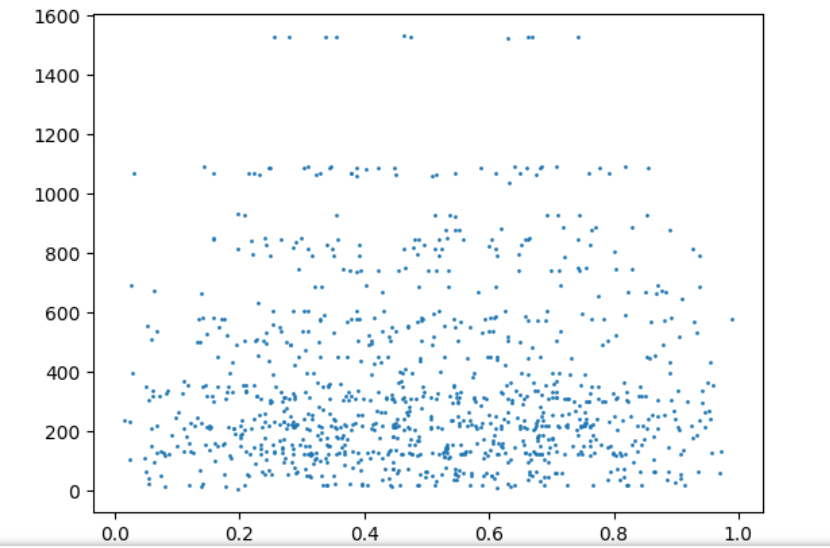

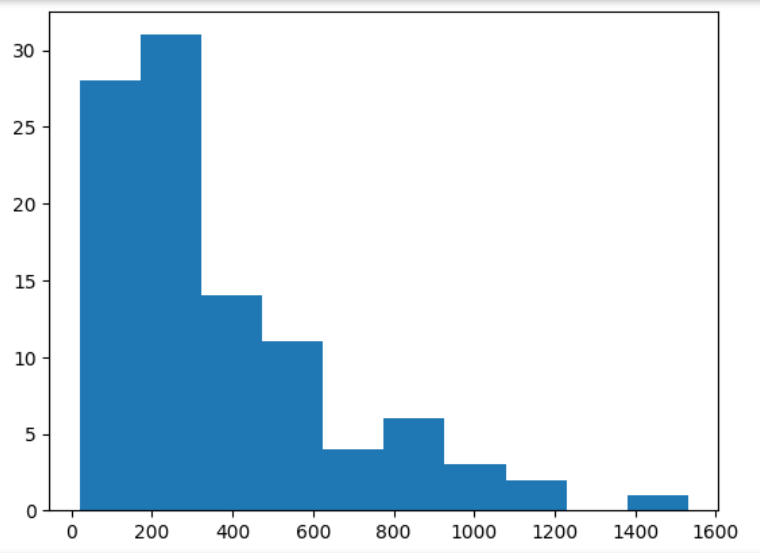

med coef, winner med coef
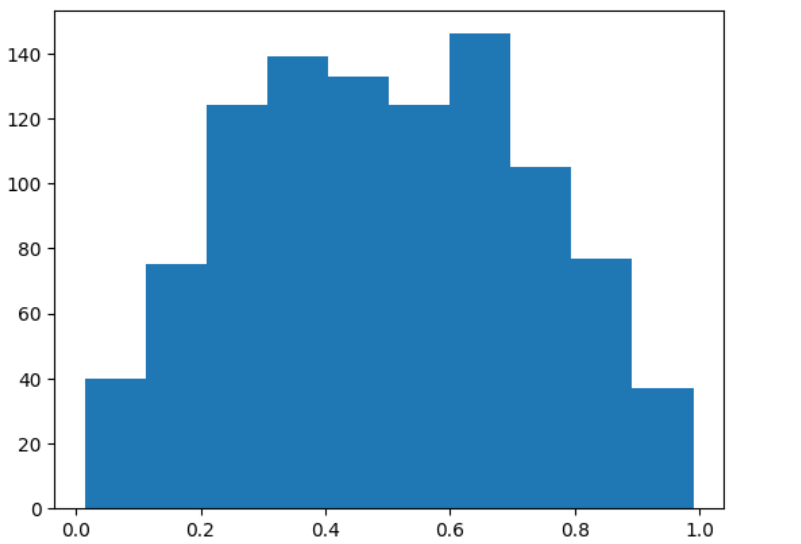
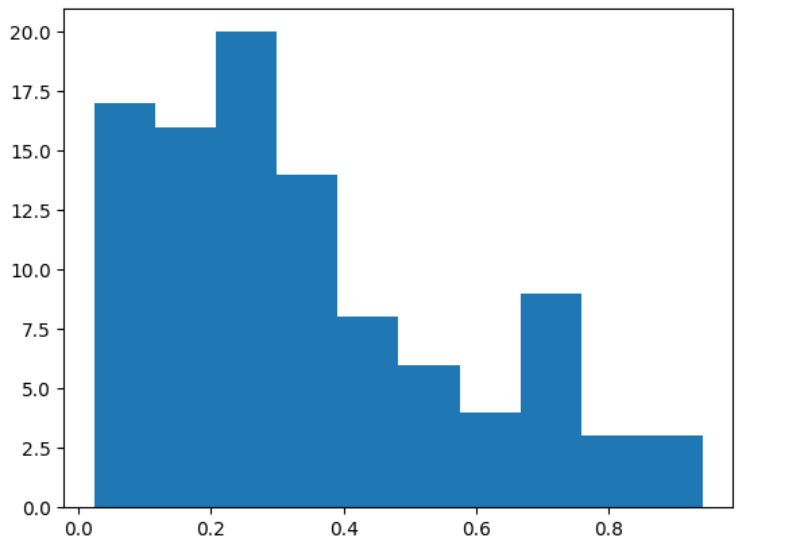eaeb4.png)

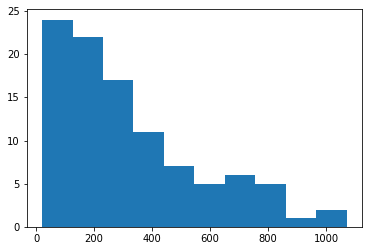

### Результаты по налогам: ничего не меняется при налоге
- Возможно, сами затраты никак не влияют на выживаемость. Надо подкорректировать коэффициенты

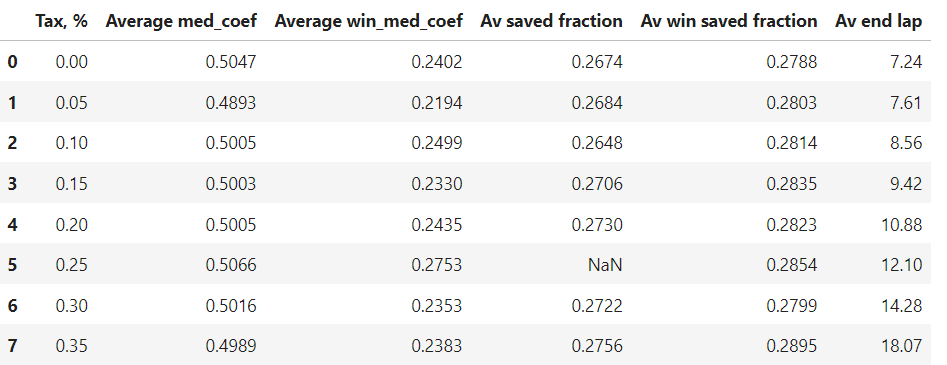

А вот это, если дисперсия уменьшается, если доноры уже донатили организации

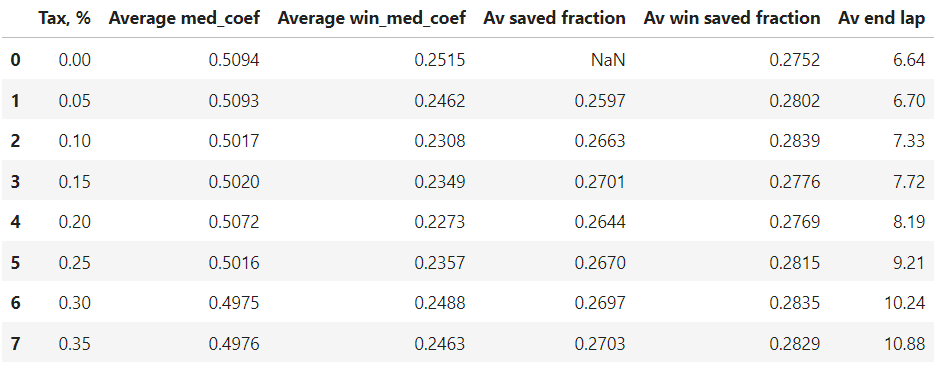
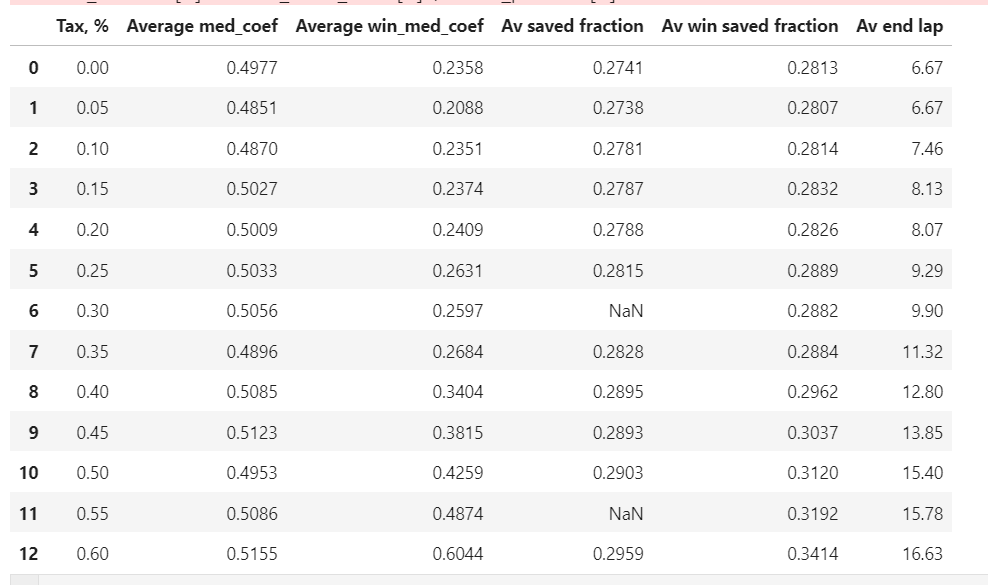